[Methodology](http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html) adapted from terrific notebooks published by Sergio Rey and Arribas and their PySal [notebooks](http://pysal.org/notebooks/lib/libpysal/weights.html) page.

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.graph_objs as go
import plotly.express as px
import os as os
import libpysal as lps
import spreg
from libpysal.weights import Queen, KNN
import esda
from sklearn.metrics.pairwise import cosine_similarity
np.random.seed(1728)

In [100]:
# Adjust directory accordingly
os.chdir('C:\\Users\\wesch\\OneDrive\\20 Spring Summer Urban Science Intensive\\nyconnect\\data')

In [101]:
# load datasets
subscription = pd.read_csv("./ACS_Internet_Subscription/subscription_acs_2018.csv")
income = pd.read_csv("./Demographics/Income/household_income_acs2018.csv")
race = pd.read_csv("./Demographics/Basic Count/tract_race_acs2018.csv")
census_tracts = gpd.read_file("./2010_Census_Tracts/geo_export_0ca1f0a1-f242-497a-9f86-91b88fc18647.shp")
mobile_rooftop = pd.read_csv("./Cellular_Towers/Mobile_Rooftop_Installations_CensusTract_2018.csv")

In [102]:
# FCC data cleaning
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }

fcc477 = pd.read_csv("Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv", converters = converters, encoding = "ISO-8859-1")
fcc477.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
# get FIPS 11: state + county + tract
fcc477["FIPS Code"] = fcc477["FIPS Code"].astype(str)
fcc477["FIPS_11"] = fcc477["FIPS Code"].str[:11]
# filter for unique providers in each tract that provide broadband service
fcc477_broadband = fcc477[(fcc477["Max Advertised Downstream Speed (mbps)"]>=25.0)&(fcc477["Max Advertised Upstream Speed (mbps)"]>=3.0)]
# prepare for merging
fcc477_broadband_grouped = fcc477_broadband.groupby(["FIPS_11", "boro"]).agg(
    num_providers = pd.NamedAgg(column = "Provider Name", aggfunc = lambda x: len(x.unique())))
fcc477_broadband_grouped.reset_index(inplace=True)
fcc477_broadband_grouped["ct2010"] = fcc477_broadband_grouped["FIPS_11"].str[5:]
fcc477_broadband_grouped["boro"] = fcc477_broadband_grouped["boro"].replace({"bronx": "Bronx",
                                                                    "brooklyn": "Brooklyn",
                                                                    "manhattan": "Manhattan",
                                                                    "staten island": "Staten Island",
                                                                    "queens": "Queens"})
# merge
fcc477_broadband_grouped_merged = fcc477_broadband_grouped.merge(census_tracts.loc[:,["boro_name", "ct2010", "ctlabel"]], right_on = ["ct2010", "boro_name"], left_on = ["ct2010", "boro"])
# new common column
fcc477_broadband_grouped_merged["BoroCTLbl"] = fcc477_broadband_grouped_merged["boro_name"] + " " + fcc477_broadband_grouped_merged["ctlabel"].astype(str)
# select only for those columns
fcc477_broadband_grouped_merged = fcc477_broadband_grouped_merged[["BoroCTLbl", "num_providers"]]

In [103]:
# data cleaning 
## Calculating race as a percentage
race = race.assign(White = lambda x: x["White"]/x["Total"]*100,
                  Black = lambda x: x["Black"]/x["Total"]*100,
                  Native = lambda x: x["Native"]/x["Total"]*100,
                  Asian = lambda x: x["Asian"]/x["Total"]*100,
                  PacificIslander = lambda x: x["Pacific Islander"]/x["Total"]*100,
                  Other = lambda x: x["Other"]/x["Total"]*100,
                  TwoOrMore = lambda x: x["Two or More"]/x["Total"]*100)
race = race[['city', 'tract', 'county', "BoroCTLbl", 'Total', 'White', 'Black', 'Native', 'Asian', 
                'PacificIslander', 'Other','TwoOrMore']]
## Calculating subscription as a percentage
subscription = subscription.assign(Mobile_Dependent = lambda x: x["Mobile_Dependent"]/x["Total"]*100,
                                   Wired_Broadband = lambda x: x["Wired_Broadband"]/x["Total"]*100,
                                   No_Internet = lambda x: x["No_Internet"]/x["Total"]*100)
## filling NAs
race = race.fillna(0)
income = income.fillna(0)
subscription = subscription.fillna(0)
## returning centroid of each census tract
census_tracts = census_tracts.assign(longitude = lambda x: x.geometry.centroid.x,
                                    latitude = lambda x: x.geometry.centroid.y)
## rename column of mobile rooftop
mobile_rooftop = mobile_rooftop.rename(columns={"NUMPOINTS":"num_rooftop_cells"})
## creating a new dataframe with all the variables 
all_vars = income.merge(race, on = ["city", "tract", "county", "BoroCTLbl"])
all_vars = all_vars.merge(subscription, on = ["city", "tract", "county", "BoroCTLbl"])
all_vars = all_vars.merge(census_tracts.loc[:, ["BoroCTLbl", "ntacode", "geometry"]], on = ["BoroCTLbl"])
all_vars = all_vars.merge(fcc477_broadband_grouped_merged, on = ["BoroCTLbl"])
all_vars = all_vars.merge(mobile_rooftop.loc[:,["num_rooftop_cells","BoroCTLbl"]], on = ["BoroCTLbl"])
## rename variables 
renamed_cols = {
    'Total_x': 'PopulationCount',
    'Total_y' : 'HouseholdCount'}
all_vars.rename(columns=renamed_cols, inplace=True)
## dropping NAs
all_vars = all_vars.dropna()

In [104]:
# Creating spatial weights matrix
weights = Queen.from_dataframe(all_vars)
weights.transform = "r"

('WARNING: ', 338, ' is an island (no neighbors)')
('WARNING: ', 1099, ' is an island (no neighbors)')
('WARNING: ', 2164, ' is an island (no neighbors)')


c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\libpysal\weights\weights.py:167: UserWarning:

The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 3 islands with ids: 338, 1099, 2164.



#### Local Spatial Autocorrelation and Local Moran's I Statistic

In [105]:
def moran_scatter_map(all_vars_df, dep_var, weights, titles, census_tracts = census_tracts):
    # Creating y_var
    y = all_vars_df[dep_var]
    # Creating a lag variable 
    lag_var = lps.weights.lag_spatial(weights, y)
    # lm for moran and plotting
    b, a  = np.polyfit(y, lag_var, 1)
    f, ax = plt.subplots(1, figsize=(9,9))

    plt.plot(y, lag_var, ".", color = "#fb8072")

    plt.vlines(y.mean(), lag_var.min(),lag_var.max(), linestyle = "--")
    plt.hlines(lag_var.mean(), y.min(), y.max(), linestyle = "--")

    # plot line of best fit using global I as slope
    plt.plot(y, a+b*y, "#8da0cb")
    plt.title("Moran Scatterplot")
    plt.ylabel("Spatial Lag of " + titles)
    plt.xlabel(titles)
    plt.show()
    
  
    #calculating local moran's i 
    li = esda.moran.Moran_Local(y, weights)

    # classifying and quadrants (xy)
    sig = 1 * (li.p_sim < 0.05)
    highhigh = 1* (sig * li.q == 1)
    lowlow = 3* (sig * li.q == 3)
    lowhigh = 2* (sig * li.q == 2)
    highlow = 4* (sig * li.q == 4)

    spots = highhigh + lowlow + lowhigh + highlow
    spots_labels = ["0 Not Sig", "1 High-High", "2 Low-High", "3 Low-Low", "High-Low"]
    labels = [spots_labels[i] for i in spots]
    
    # plotting map
    from matplotlib import colors
    hmap = colors.ListedColormap(["#d9d9d9", "#fb8072", "#8dd3c7", "#80b1d3", "#bebada"])
    f, ax = plt.subplots(1, figsize=(9,9))
    relevant_tracts = all_vars_df.loc[:,["geometry"]]
    relevant_tracts = gpd.GeoDataFrame(relevant_tracts, crs = census_tracts.crs)
    relevant_tracts.assign(cl=labels).plot(column = "cl", categorical = True, k = 2, cmap = hmap, linewidth = 0.1, 
                                           ax = ax, edgecolor = "white", legend = True)
    ax.set_axis_off()
    ax.set_title("Spatial Association for " + titles)
    plt.show()

**Moran's I Scatterplot**:  
We are interested in Quadrants 1 and 3, the NE and SW respectively. If there is no spatial autocorrelation, we would not see such a strong positive correlation. The two quadrants represent clusters of contiguous Census Tracts with similar levels of home wired broadband subscription.  
  
The two dashed lines are the means of both axes. Values to below and above this are *low* and *high* respectively.   
  
**Spatial Association Map**:  
Here we can see a map of similarly valued clusters.

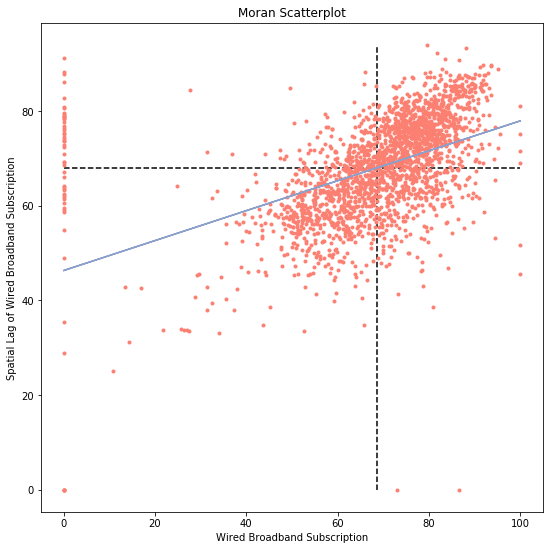

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



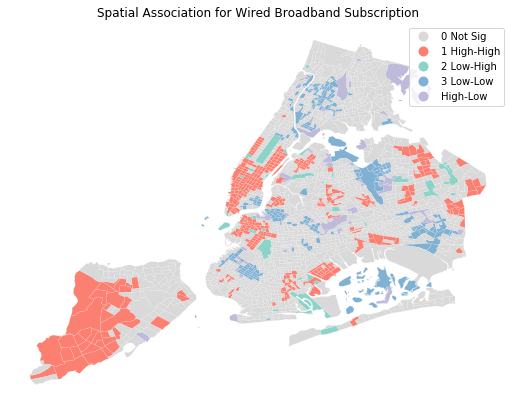

In [106]:
moran_scatter_map(all_vars, "Wired_Broadband", weights, "Wired Broadband Subscription")

And what about the number of ISPs? Are they spatially autocorrelated too

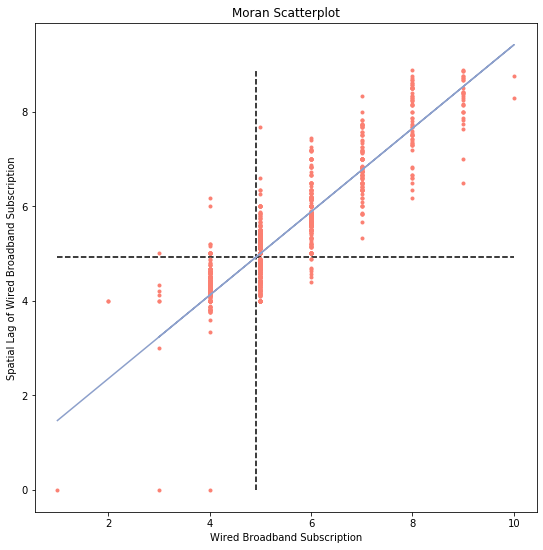

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



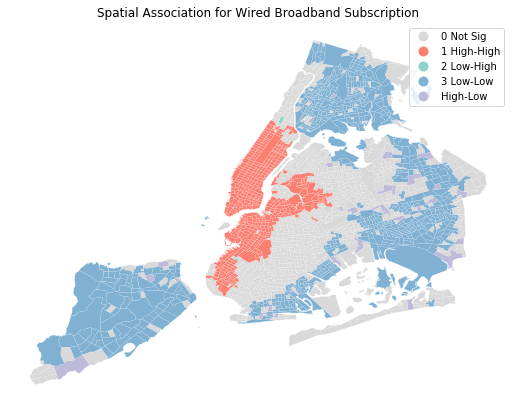

In [107]:
moran_scatter_map(all_vars, "num_providers", weights, "Wired Broadband Subscription")

Now we pivot towards mobile broadband dependence.

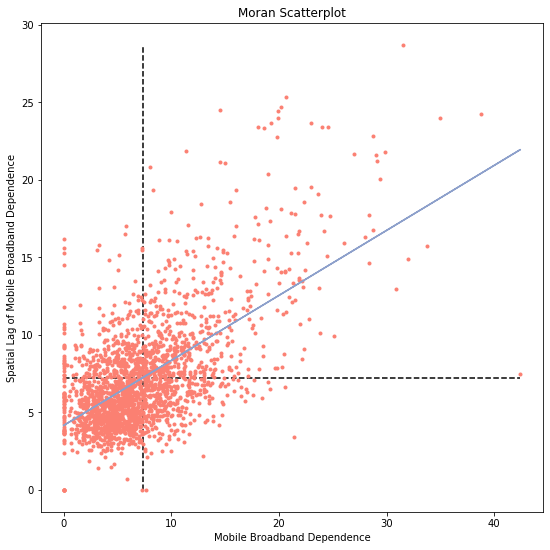

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



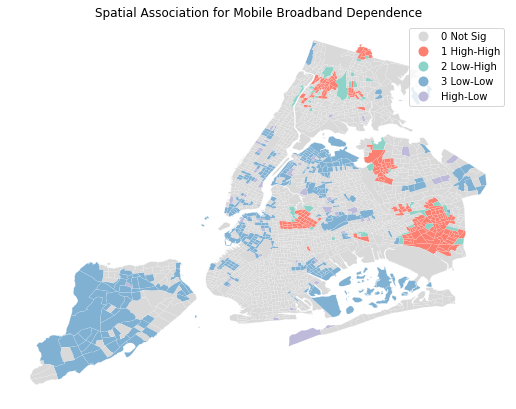

In [108]:
moran_scatter_map(all_vars, "Mobile_Dependent", weights, "Mobile Broadband Dependence")

Repeating this analysis for mobile broadband dependence, we can see that a not entirely dissimilar pattern emerge. Clusters of census tracts with high mobile broadband dependence tend to be close to the areas wih low wired broadband subscription rates. But it is not a perfect match, suggesting that mobile broadband is not a perfect substitution.

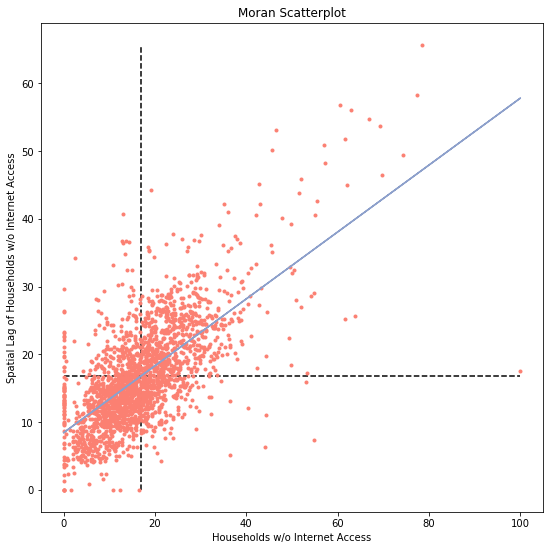

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



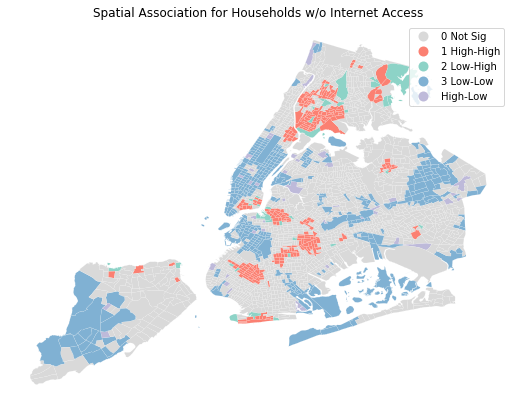

In [109]:
moran_scatter_map(all_vars, "No_Internet", weights, "Households w/o Internet Access")

This is a much more perfect match with *wired broadband subscription* than *mobile broadband dependence*. Clusters with high levels of households without internet access tend to be found around LES, Coney Island, South Williamsburg, Flatbush, Brownsville, East Harlem, and much of southern Bronx. Uncoincidentally, these tend to be areas with lower incomes and more racial minorities.

#### Spatial Regression for Wired Broadband

Why are these spatial regressions special? They take into account spatial fixed effects. They do not assume that the dependent variable behaves uniformly acrss spacewith systematic effects. In so doing, we introduce econometrically the notion of spatial heterogeneity by allowing the constant term (regime) to vary geographically.

In [111]:
y = all_vars.loc[:,["Wired_Broadband"]]
indep_vars = all_vars[['Households (HH) Count',
       'HH 0-10k', 'HH 10k-15k', 'HH 15k-25k', 'HH 25k-35k', 'HH 35k-50k',
       'HH 50k-75k', 'HH 75k-100k', 'HH 100k-150k', 'HH 150k-200k',
       'HH 200k-UP', 'PopulationCount', 'White', 'Black', 'Native', 'Asian',
       'PacificIslander', 'Other', 'TwoOrMore', 'num_providers', "Household Median Income", "Household Mean Income"]]

In [112]:
regimes = list(all_vars["county"])

In [113]:
m1 = spreg.OLS_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [114]:
print(m1.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME Bronx
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Bronx_WiredBroadband_Pct                Number of Observations:         339
Mean dependent var  :     60.9928                Number of Variables   :          23
S.D. dependent var  :     12.6810                Degrees of Freedom    :         316
R-squared           :      0.7485
Adjusted R-squared  :      0.7310
Sum squared residual:   13667.326                F-statistic           :     42.7585
Sigma-square        :      43.251                Prob(F-statistic)     :   3.971e-81
S.E. of regression  :       6.577                Log likelihood        :   -1107.622
Sigma-square ML     :      40.317                Akaike info criterion :    2261.243
S.E of regression ML:      6.3495                Schwarz criterion     :    2349.241

------------

From the above, we can conclude that race is not statistically significant in testing for wired broadband subscription. Income is a much better predictor. Interesting enough, the number of providers is **NOT** significant either.  
At the bottom of the summary object are four statistics for spatial dependence. I tested whether the residuals of the regression are spatially correlated, against the null of a random distribution over a designated space, NYC's census tracts in this case. Since, the tests reject the null hypothesis that error terms are randomly distributed in space, the normal OLS assumption of randomness is violated. Thus, OLS on its own is not particularly well suited. 

In [116]:
m2 = spreg.GM_Lag_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [117]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES - REGIMES
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :WiredBroadband_Pct                Number of Observations:        2165
Mean dependent var  :     68.6500                Number of Variables   :         116
S.D. dependent var  :     16.2861                Degrees of Freedom    :        2049
Pseudo R-squared    :      0.8289
Spatial Pseudo R-squared:  0.8179

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
      Bronx_CONSTANT      -5.4927269       5.8687356      -0.9359302       0.3493091
Bronx_Households (HH) Count      -0.0002148       0.0011389      -0.1885960       0.8504095
    

The results are roughly similar, and we can see that the spatially lagged variable is significant. What this means is that there is some form of spatial interaction between census tracts that causes some autocorrelation in wired broadband subscription. Even if we are not entirely convinced that a regression model can predict the rates of household broadband subscription, we want to see whether a lagged model can reduce MSE. Interestingly enough, even though the number of providers is not always significant, there is still some evidence of omitted variable bias. MSE was higher in the regressions without the number of providers. 

As a test, we can see what happens if we do not take into account fixed effects by measuring the differences in MSEs. Clearly, taking into account fixed effects at the borough level can reduce the mean squared errors very significantly.

In [118]:
m1_2 = spreg.OLS(y = np.array(y), x = np.array(indep_vars),
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")
m2_2 = spreg.GM_Lag(y = np.array(y), x = np.array(indep_vars),
                       w = weights, spat_diag = True,
                       name_x = indep_vars.columns.tolist(), name_y = "WiredBroadband_Pct")

In [119]:
from sklearn.metrics import mean_squared_error as mse

mses = pd.Series({'F.E. OLS': mse(y, m1.predy.flatten()),
                'F.E. Lag': mse(y, m2.predy.flatten()),
                'OLS': mse(y, m1_2.predy.flatten()),
                'Lag': mse(y, m2_2.predy.flatten())})
mses.sort_values()

F.E. Lag    45.360534
F.E. OLS    48.649629
Lag         59.826489
OLS         62.861168
dtype: float64

#### Spatial Regression for Mobile Broadband

In [120]:
y = all_vars.loc[:,["Mobile_Dependent"]]
indep_vars = all_vars[['Households (HH) Count',
       'HH 0-10k', 'HH 10k-15k', 'HH 15k-25k', 'HH 25k-35k', 'HH 35k-50k',
       'HH 50k-75k', 'HH 75k-100k', 'HH 100k-150k', 'HH 150k-200k',
       'HH 200k-UP', 'PopulationCount', 'White', 'Black', 'Native', 'Asian',
       'PacificIslander', 'Other', 'TwoOrMore', 'num_providers', "num_rooftop_cells"]]
m3 = spreg.GM_Lag_Regimes(y = np.array(y), x = np.array(indep_vars), regimes = regimes,
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "MobileBroadbandDependence_Pct")
print(m3.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES - REGIMES
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :MobileBroadbandDependence_Pct                Number of Observations:        2165
Mean dependent var  :      7.3482                Number of Variables   :         111
S.D. dependent var  :      5.0429                Degrees of Freedom    :        2054
Pseudo R-squared    :      0.4564
Spatial Pseudo R-squared:  0.3464

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
      Bronx_CONSTANT     -13.0229073       4.4272242      -2.9415514       0.0032657
Bronx_Households (HH) Count      -0.0016507       0.0007513      -2.1971789       0.0

In [121]:
m3_2 = spreg.GM_Lag(y = np.array(y), x = np.array(indep_vars),
                  w = weights,spat_diag = True,
                  name_x = indep_vars.columns.tolist(), name_y = "MobileBroadbandDependence_Pct")

In [122]:
mses = pd.Series({'F.E. Lag': mse(y, m3.predy.flatten()),
                 'Lag': mse(y, m3_2.predy.flatten())})
mses.sort_values()

F.E. Lag    13.820372
Lag         16.375567
dtype: float64

The same effect can be seen here. Taking into spatial fixed effects have a significant impact on reducing MSEs.

#### Demographics within Moran I Clusters

Let us first look at household wifi subscription rates.

In [123]:
# Creating y_var
y = all_vars["Wired_Broadband"]
    
#calculating local moran's i 
li = esda.moran.Moran_Local(y, weights)

# classifying and quadrants (xy)
sig = 1 * (li.p_sim < 0.05)
highhigh = 1* (sig * li.q == 1)
lowlow = 3* (sig * li.q == 3)
lowhigh = 2* (sig * li.q == 2)
highlow = 4* (sig * li.q == 4)

spots = highhigh + lowlow + lowhigh + highlow
spots_labels = ["0 Not Sig", "1 High-High", "2 Low-High", "3 Low-Low", "High-Low"]
labels = [spots_labels[i] for i in spots]

# adding labels
demographics = all_vars.iloc[:,5:24]
demographics = demographics.assign(hh_broadband_m1=labels)

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\esda\moran.py:886: RuntimeWarning:

invalid value encountered in true_divide

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

c:\users\wesch\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning:

invalid value encountered in greater_equal



In [124]:
highs = demographics.loc[(demographics.hh_broadband_m1=="1 High-High")]
highs = highs.loc[:, ["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
high_cosine_sim = cosine_similarity(highs, highs)
lows = demographics.loc[((demographics.hh_broadband_m1=="3 Low-Low"))]
lows = lows.loc[:, ["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
lows_cosine_sim = cosine_similarity(lows, lows)
demographics_num = demographics.loc[:,["HH 0-10k", "HH 10k-15k", "HH 15k-25k", "HH 25k-35k", "HH 35k-50k", "HH 50k-75k", "HH 75k-100k", "HH 100k-150k", "HH 150k-200k", "HH 200k-UP", "PopulationCount", "White", "Black", "Native", "Asian", "PacificIslander", "Other", "Household Median Income", "Household Mean Income"]]
demographics_cosine_sim = cosine_similarity(demographics_num, demographics_num)

In [125]:
print("Average cosine similarity (%) between \n" + 
     "High-High Cluster: " + str(round(np.mean(high_cosine_sim)*100,2)) + 
     "\nLow-Low Cluster: "+ str(round(np.mean(lows_cosine_sim)*100,2)) + 
     "\nAll Census Tracts: "+ str(round(np.mean(demographics_cosine_sim)*100,2)))

Average cosine similarity (%) between 
High-High Cluster: 98.68
Low-Low Cluster: 90.6
All Census Tracts: 94.01


Demographically, it appears that census tracts with high levels of household broadband subscription are more homogenous than those with low levels of household broadband subscription.  